# Wiki

**Input**
- `click_behavior.csv` -  output from `reco-api`
- `items_20220327.csv` - query from SAP Commerce
- `img_sim.csv` - output from `reco-api` image similarity service

**Output**
A single CSV table with following attributes:
- `click_item` - depdendent variable
- `r1f_cat` - 1 if recommended item at position 1 shares a category with focal product, 0 else
- `r1r_cat` - 1 if recommended item at position 1 shares a category with other recommended products, 0 else

# Import Packages & Load Data

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# VERSION = '20220410'
VERSION = '20220428'

df = pd.read_csv(f'../Data/click_behavior_{VERSION}.csv')
df_items = pd.read_csv(f'../Data/items_20220327.csv')
df_img = pd.read_csv(f'../Data/img_sim.csv')

# NOTE: for treatment there are products where no recommendations are available this removes some users totally ... therefore total number of users in treatment is smaller than in random
df = df.dropna()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13980 entries, 0 to 16995
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_uid          13980 non-null  object 
 1   group             13980 non-null  object 
 2   is_mobile         13980 non-null  int64  
 3   timestamp         13980 non-null  object 
 4   focal_item        13980 non-null  int64  
 5   click_item        13980 non-null  int64  
 6   click             13980 non-null  int64  
 7   click_pos         13980 non-null  int64  
 8   reco_item1        13980 non-null  int64  
 9   reco_item2        13980 non-null  int64  
 10  reco_item3        13980 non-null  int64  
 11  focal_item_price  13980 non-null  float64
 12  reco_item1_price  13980 non-null  float64
 13  reco_item2_price  13980 non-null  float64
 14  reco_item3_price  13980 non-null  float64
dtypes: float64(4), int64(8), object(3)
memory usage: 1.7+ MB


In [74]:
# df.groupby(['group'])['user_uid'].nunique()
# Consideration set size
df[df['user_uid'] != '6222950081ece9c26d2c4931'].groupby(['user_uid', 'group'])['user_uid'].agg(
    css='count').reset_index().groupby('group')['css'].mean()

group
cf_ib     2.747857
random    3.422182
Name: css, dtype: float64

## Rename Control & Treatment Group

In [75]:
m = {'cf_ib': 'treatment', 'random': 'control'}
df['group'] = df.group.map(m)

## Create Focal Item - Recommended Item Set of Tuples

In [76]:
# Create set of unique tuples (focal item, recommended item)
focal_reco_tuples = set()
for index, row in df[['focal_item', 'reco_item1', 'reco_item2', 'reco_item3']].iterrows():
    for i in range(3):
        focal_reco_tuples.add((row['focal_item'], row[f'reco_item{i + 1}']))

# Distance Focal Item - Recommended Items

This metrics are used to operationalize the local contrast effect.

## Categories for Focal Item and Recommended Items

Get the categories for the focal and the recommended items. When column value is `NaN` the particular item could not be found in the `items.csv`. If column value equals `{}` the item does not belong to any category.

In [77]:
item_cat_df = df_items.groupby('PRODUCT_CODE')['CATEGORY_SOURCE'].unique()
item_cat_df = item_cat_df.apply(lambda x: [i for i in x if not '2' in i])  # Remove "Warengruppe"

df[['f_cat', 'r1_cat', 'r2_cat', 'r3_cat']] = 0

for index, row in df.iterrows():
    focal_item = row['focal_item']
    try:
        focal_cats = item_cat_df.loc[focal_item]
        df.at[index, 'f_cat'] = set(focal_cats)
    except:
        pass
    for i in range(3):
        reco_item = row[f'reco_item{i + 1}']
        try:
            reco_cats = item_cat_df.loc[reco_item]
            df.at[index, f'r{i + 1}_cat'] = set(reco_cats)
        except:
            pass

## Categorical Similarity

Calculate if the focal and recommended items share at least one category. Also check if the first (second, third) recommended item shares categories with the other recommended items.

In [78]:
df[['f_r1_cat', 'f_r2_cat', 'f_r3_cat', 'r1_r_cat', 'r2_r_cat', 'r3_r_cat']] = 0

for index, row in df.iterrows():
    focal_item = row['focal_item']
    try:
        focal_cats = item_cat_df.loc[focal_item]
    except:
        pass
    for i in range(3):
        reco_item = row[f'reco_item{i + 1}']
        # Focal Item -Recommended Item
        try:
            reco_cats = item_cat_df.loc[reco_item]
            df.loc[index, f'f_r{i + 1}_cat'] = int(len(set.intersection(set(focal_cats), set(reco_cats))) > 0)
            # df.loc[index, f'f_r{i + 1}_cat'] = int(len(set.intersection(set(focal_cats), set(reco_cats))))
        except:
            pass

        # Recommended Item - Other Recommended Items
        try:
            other_reco_pos = [x for x in [0, 1, 2] if x != i]
            other_reco_cat = []
            for j in other_reco_pos:
                other_reco_item = row[f'reco_item{j + 1}']
                try:
                    other_reco_cat.extend(item_cat_df[other_reco_item])
                except:
                    pass
            df.loc[index, f'r{i + 1}_r_cat'] = int(len(set.intersection(set(other_reco_cat), set(reco_cats))) > 0)
            # df.loc[index, f'r{i + 1}_r_cat'] = int(len(set.intersection(set(other_reco_cat), set(reco_cats))))
        except:
            pass

In [79]:
df['f_r_cat'] = 0

for index, row in df[['f_r1_cat', 'f_r2_cat', 'f_r3_cat']].iterrows():
    share_cat = int(row[['f_r1_cat', 'f_r2_cat', 'f_r3_cat']].sum())
    df.loc[index, 'f_r_cat'] = share_cat

In [80]:
for index, row in df.iterrows():
    if row['click'] == 1:
        i = row['click_pos']
        try:
            df.loc[index, 'c_r_cat'] = row[f'r{i}_r_cat']
        except:
            pass

In [81]:
df[df['click'] == 1]

,user_uid,group,is_mobile,timestamp,focal_item,click_item,click,click_pos,reco_item1,reco_item2,...,r2_cat,r3_cat,f_r1_cat,f_r2_cat,f_r3_cat,r1_r_cat,r2_r_cat,r3_r_cat,f_r_cat,c_r_cat
282,6222d9ab81ece9c26db359bd,treatment,1,2022-03-05T03:34:55.365668,1257,1062,1,1,1062,1234,...,"{110 Jahre Austria Wien, Küche}",{Accessoires},1,0,0,0,0,0,1,0.0
285,6222f33881ece9c26de9975b,treatment,0,2022-03-05T05:24:17.894539,1162,1269,1,1,1269,1211,...,"{Shirts & Polos Herren, Von Fans für Fans}",{Shirts & Polos Herren},1,1,1,1,1,1,3,1.0
287,6222f33881ece9c26de9975b,treatment,0,2022-03-05T05:28:00.667101,1179,1200,1,2,1312,1200,...,"{Von Fans für Fans, Herren Accessoires, Matchtag}","{Shirts & Polos Herren, Von Fans für Fans}",0,0,0,0,1,1,0,1.0
290,6222f33881ece9c26de9975b,treatment,0,2022-03-05T05:29:30.488174,614,606,1,1,606,1192,...,"{Jacken, Fast ablösefrei}",{Accessoires},1,1,0,1,1,0,2,1.0
297,6222f33881ece9c26de9975b,treatment,0,2022-03-06T14:09:44.457908,1292,1256,1,1,1256,447,...,{Accessoires},{Kappen & Hauben},1,0,1,1,0,1,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16963,626a37baf5270611cf32d601,control,1,2022-04-28T06:45:43.578423,1312,1208,1,2,479,1208,...,"{Bett & Bad, Violettes Wohnzimmer}",{Shirts & Polos Herren},0,1,0,0,0,0,1,0.0
16978,626a45bbf5270611cf59b38b,treatment,1,2022-04-28T09:33:15.700240,1175,821,1,2,612,821,...,"{Kinder & Babies Training, Herren Training, Da...",{Accessoires},1,0,0,0,0,0,1,0.0
16979,626a45bbf5270611cf59b38b,treatment,1,2022-04-28T09:33:22.023707,821,1280,1,2,853,1280,...,"{Kinder & Babies, Kinder & Babies Training}",{Kinder & Babies Training},1,1,1,1,1,1,3,1.0
16980,626a45bbf5270611cf59b38b,treatment,1,2022-04-28T09:33:27.672706,1280,1266,1,3,1303,1267,...,"{Kinder & Babies, Kinder & Babies Training}","{Kinder & Babies, Kinder & Babies Training}",1,1,1,1,1,1,3,1.0


## Price Distance

Price was already given by `reco-api`, therefore calculation of prices not needed (compared to categories from above).

In [82]:
df[['f_r1_price', 'f_r2_price', 'f_r3_price']] = 0

for index, row in df[['focal_item_price', 'reco_item1_price', 'reco_item2_price', 'reco_item3_price']].iterrows():
    f_price = row['focal_item_price']
    for i in range(3):
        r_price = row[f'reco_item{i + 1}_price']
        df.loc[index, f'f_r{i + 1}_price'] = (f_price - r_price)

In [83]:
df['f_r_price'] = 0

for index, row in df[['focal_item_price', 'reco_item1_price', 'reco_item2_price', 'reco_item3_price']].iterrows():
    reco_price_mean = row[['reco_item1_price', 'reco_item2_price', 'reco_item3_price']].mean()
    df.loc[index, 'r_price_mean'] = reco_price_mean.round(2)
    df.loc[index, 'f_r_price'] = (row['focal_item_price'] - reco_price_mean).round(5)

## Visual Similarity

In [84]:
df[['f_r1_img', 'f_r2_img', 'f_r3_img']] = 0

for index, row in df[['focal_item', 'reco_item1', 'reco_item2', 'reco_item3']].iterrows():
    f = row['focal_item']
    for i in range(3):
        r = row[f'reco_item{i + 1}']
        score = df_img[(df_img['item1'] == str(r)) & (df_img['item2'] == str(f)) | (df_img['item1'] == str(f)) & (
                df_img['item2'] == str(r))]['sim'].values
        if len(score) == 1:
            df.loc[index, f'f_r{i + 1}_img'] = score

In [85]:
df['f_r_img'] = 0

for index, row in df[['f_r1_img', 'f_r2_img', 'f_r3_img']].iterrows():
    reco_img_mean = row[['f_r1_img', 'f_r2_img', 'f_r3_img']].mean()
    df.loc[index, 'f_r_img'] = reco_img_mean

# Inner Congruence / Distance Recommended Items

# Create CSV

In [86]:
# df = df.drop(columns=['reco_item1', 'reco_item2', 'reco_item3', 'f_cat', 'r1_cat', 'r2_cat', 'r3_cat'])
df

,user_uid,group,is_mobile,timestamp,focal_item,click_item,click,click_pos,reco_item1,reco_item2,...,c_r_cat,f_r1_price,f_r2_price,f_r3_price,f_r_price,r_price_mean,f_r1_img,f_r2_img,f_r3_img,f_r_img
0,6222885b81ece9c26d146eff,treatment,1,2022-03-04T21:45:05.603683,1239,0,0,0,1173,1240,...,NaN,15.0,-30.0,15.0,0.00000,29.90,0.76596,0.87389,0.00000,0.546617
1,6222886181ece9c26d147a81,control,1,2022-03-04T21:45:25.651769,1189,0,0,0,487,1156,...,NaN,-4.2,-117.2,-4.1,-41.83333,43.63,0.00000,0.00000,0.71523,0.238410
2,6222886181ece9c26d147a81,control,1,2022-03-04T21:46:27.444002,686,0,0,0,642,1256,...,NaN,-12.4,-2.4,-5.4,-6.73333,29.23,0.76480,0.00000,0.00000,0.254933
3,6222886181ece9c26d147a81,control,1,2022-03-04T21:46:32.827091,686,0,0,0,436,456,...,NaN,7.6,14.5,-2.4,6.56667,15.93,0.00000,0.00000,0.79375,0.264583
4,6222886181ece9c26d147a81,control,1,2022-03-09T21:44:59.657430,1189,0,0,0,1279,501,...,NaN,-28.1,-33.2,-8.2,-23.16667,24.97,0.74384,0.00000,0.00000,0.247947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16990,626a6d6cf5270611cfba3296,treatment,0,2022-04-28T10:34:23.223689,1166,0,0,0,478,1144,...,NaN,22.0,22.0,26.0,23.33333,6.57,0.00000,0.73201,0.00000,0.244003
16991,626a7492f5270611cfca29f6,treatment,1,2022-04-28T11:04:08.576945,1317,1305,1,1,1305,1312,...,0.0,0.0,10.0,-15.1,-1.70000,31.60,0.75408,0.00000,0.71297,0.489017
16993,626a7b42f5270611cfd924f4,control,1,2022-04-28T11:33:43.088568,1259,0,0,0,755,1130,...,NaN,15.9,19.9,20.0,18.60000,11.30,0.00000,0.00000,0.00000,0.000000
16994,626a7b42f5270611cfd924f4,control,1,2022-04-28T11:33:57.778352,1162,0,0,0,1207,597,...,NaN,25.0,24.9,36.9,28.93333,10.97,0.00000,0.00000,0.00000,0.000000


In [87]:
df.to_csv(f'../Data/click_behavior_processed_{VERSION}.csv', index=False)

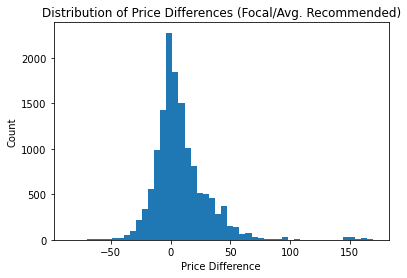

In [88]:
_ = plt.hist(df['f_r_price'], bins=50)
_ = plt.title('Distribution of Price Differences (Focal/Avg. Recommended)')
_ = plt.xlabel('Price Difference')
_ = plt.ylabel('Count')

$$ (p1, p2, p3) = \beta_0  + category*x_1 + price*x_2 + visual*x_3$$

$$
x_1 = \begin{pmatrix}
1 & 0 & 1
\end{pmatrix}'\in\mathbb R^{3\times 1}
$$